In [1]:
from data_parser import get_data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from kernel_methods import KernelSVC
from kernels import DirectProductGraphKernel, DiracKernel, AllNodePairsKernel, AllEdgePairsKernel, WL_relabelling, WL_relabelling_with_edges
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from tqdm import tqdm
from kernels import WLKernel

training_data, training_labels, test_data = get_data()


In [243]:
X_train, X_test, y_train, y_test = train_test_split(training_data, training_labels, test_size=0.33)
X_train = training_data
y_train = training_labels
y_train = np.array(y_train)
y_train = (2*(y_train-.5))

y_test = np.array(y_test)
y_test = (2*(y_test-.5))

In [244]:
n = len(X_train)
kernel = WLKernel(h = 4, relabelling_method= WL_relabelling_with_edges, lmbda= 1.1).kernel
kernel_X = np.ones((n,n)) 
for i in tqdm(range(n)):
    for j in range(i+1,n):
        similarity = kernel(X_train[i],X_train[j])             
        kernel_X[i,j] = similarity
        kernel_X[j,i] = similarity

100%|██████████| 6000/6000 [8:21:11<00:00,  5.01s/it]   


In [245]:
np.save("kernel_train_all", kernel_X)

In [40]:
### val

n_test = 100
kernel = WLKernel(h = 4, relabelling_method= WL_relabelling_with_edges, lmbda = 1.1).kernel
kernel_X_test = np.ones((n_test,n))
for i in tqdm(range(n_test)):
    for j in range(n):
        similarity = kernel(X_test[i],X_train[j])             
        kernel_X_test[i,j] = similarity

100%|██████████| 100/100 [09:47<00:00,  5.87s/it]


In [344]:
kernel_X = np.load("kernel_train_all.npy")
kernel_X_test = np.load("kernel_test_all.npy")

In [345]:
n = len(X_train)
kernel = WLKernel(h = 4, relabelling_method= WL_relabelling_with_edges, lmbda= 1.1).kernel
for i in tqdm(range(n)):
    similarity = kernel(X_train[i],X_train[i])             
    kernel_X[i,i] = similarity

100%|██████████| 6000/6000 [00:20<00:00, 288.65it/s]


In [353]:
gamma = 1/9

In [358]:
new_kernel_X = np.ones((n,n))

for i in tqdm(range(n)):
    for j in range(i+1, n):
        new_kernel_X[i,j] = (kernel_X[i,i] + kernel_X[j,j] - 2*kernel_X[i,j])
        new_kernel_X[j,i] = new_kernel_X[i,j] 

100%|██████████| 6000/6000 [00:40<00:00, 149.15it/s]


In [359]:
np.save("distances_paul", new_kernel_X)

In [360]:
n_test = len(test_data)

diag_test = np.zeros(n_test)

for i in tqdm(range(n_test)):
    similarity = kernel(test_data[i],test_data[i])             
    diag_test[i] = similarity

new_kernel_test = np.ones((n_test,n))

for i in tqdm(range(n_test)):
    for j in range(n):
        new_kernel_test[i,j] = (kernel_X[j,j] + diag_test[i] - 2*kernel_X_test[i,j])


100%|██████████| 2000/2000 [00:28<00:00, 69.07it/s] 


In [361]:
np.save("distance_test_paul", new_kernel_test)

In [356]:
# clf = KernelSVC(C = 1, kernel = None, epsilon=1e-3, precomputed=kernel_X[:1000,:1000], class_weight = "balanced", probability = False, l = .00005)
# kernel_X = np.load("kernel_train_all.npy")
clf = SVC(C = 1, kernel = "precomputed", class_weight = "balanced")
clf.fit(kernel_X, np.array(y_train))
# clf.fit(kernel_X, np.array(y_train), 1000)
# clf.fit(kernel_X[:1000,:1000], y_train[:1000],2)

SVC(C=1, class_weight='balanced', kernel='precomputed')

In [340]:
print(clf._dual_coef_)
print(clf._support_)

# np.save("dual_coeff_all_3", clf._dual_coef_)
# np.save("support_all_3", clf.support_)


[[ 0.02115963  0.01309082  0.0231266  ... -0.24212066 -0.32534997
  -0.33614978]]


AttributeError: 'SVC' object has no attribute '_support_'

In [341]:
preds = clf.decision_function(kernel_X)
roc_auc_score(y_train,preds)
#preds

1.0

In [297]:
preds = kernel_X[:,clf.support_].dot(clf._dual_coef_.T) + clf._intercept_
-preds
#roc_auc_score(y_test[:n_test],-preds[:])

array([[-4.17712577],
       [15.89628447],
       [-4.90309778],
       ...,
       [-2.81940947],
       [ 5.49498475],
       [ 4.06369044]])

In [290]:
n_test = len(test_data)
kernel = WLKernel(h = 4, relabelling_method= WL_relabelling_with_edges, lmbda = 1.1).kernel
kernel_X_test = np.ones((n_test,n))
for i in tqdm(range(n_test)):
    for j in range(n):
        similarity = kernel(test_data[i],X_train[j])             
        kernel_X_test[i,j] = similarity

100%|██████████| 2000/2000 [8:53:49<00:00, 16.01s/it]  


In [291]:
# np.save("kernel_test_all",kernel_X_test)

In [357]:
import pandas as pd

preds = clf.decision_function(new_kernel_test)
dataframe = pd.DataFrame({"Predicted": preds}) 
dataframe.index += 1

dataframe.to_csv('test_pred_all_gaussian.csv',index_label='Id')

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

valid_preds = pd.read_csv("validation_pred.csv")

x = valid_preds["Predicted"].values

test_preds = pd.read_csv("test_pred_06.csv")

y = test_preds["Predicted"].values

x = valid_preds["Predicted"].values

(array([  3.,  11.,  61., 129., 439., 646., 524., 135.,  41.,  11.]),
 array([-48.90872828, -39.52513571, -30.14154314, -20.75795057,
        -11.37435801,  -1.99076544,   7.39282713,  16.7764197 ,
         26.16001226,  35.54360483,  44.9271974 ]),
 <BarContainer object of 10 artists>)

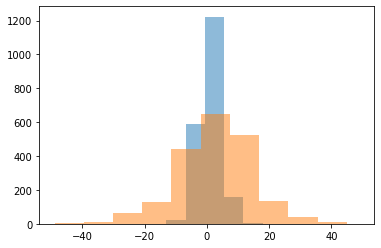

In [12]:
plt.hist(3*x, alpha = .5)
plt.hist(y,alpha = .5)